# Capstone project for IBM data science course

In [1]:
#first run the following cells to ensure have the proper setup, then restart the kernel
!pip install --upgrade pip
!pip install tensorflow==2.3.1 --use-feature=2020-resolver
!pip install tensorflow_datasets --use-feature=2020-resolver
!pip install tensorflow_data_validation --use-feature=2020-resolver

Requirement already up-to-date: pip in /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages (20.2.4)


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tempfile
from tensorflow.keras import layers

%load_ext tensorboard

In [3]:
from contextlib import suppress
import os
import matplotlib.pyplot as plt

In [4]:
print(tf.__version__)

2.3.1


In [44]:
ds,ds_info = tfds.load('beans',as_supervised=True,with_info=True)

In [45]:
ds_info

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [8]:
BATCH_SIZE = 32
IMG_SIZE = 224

size = (IMG_SIZE, IMG_SIZE)

In [46]:
#reshape images to samller size
train_ds = ds['train'].map(lambda image, label: (tf.image.resize(image, size), label)).batch(BATCH_SIZE)
test_ds = ds['test'].map(lambda image, label: (tf.image.resize(image, size), label)).batch(BATCH_SIZE)

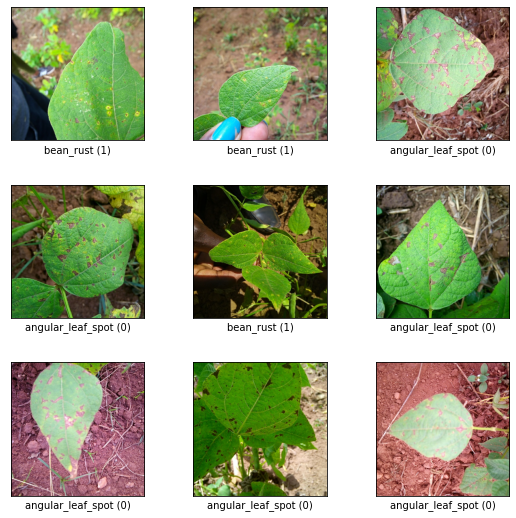

In [10]:
#train dataset examples
fig = tfds.show_examples(ds['train'], ds_info)

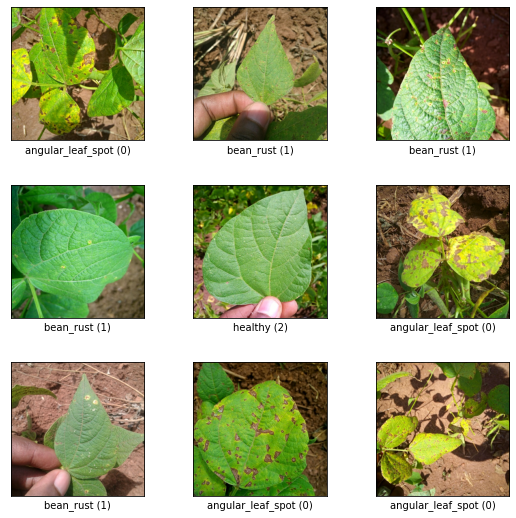

In [11]:
#test datasets example
fig = tfds.show_examples(ds['test'], ds_info)

In [13]:
# Building our first model
model = tf.keras.Sequential([
  #preprocess resize and scale image
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
  #model
  tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')])
    

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['acc'])

In [14]:
model.fit(train_ds, epochs=10,validation_data=test_ds)

Epoch 1/10
33/33 [==============================] - 20s 602ms/step - loss: 1.0686 - acc: 0.4458 - val_loss: 0.9151 - val_acc: 0.6250
Epoch 2/10
33/33 [==============================] - 18s 557ms/step - loss: 0.8156 - acc: 0.6344 - val_loss: 0.7343 - val_acc: 0.6641
Epoch 3/10
33/33 [==============================] - 19s 564ms/step - loss: 0.6358 - acc: 0.7321 - val_loss: 0.7026 - val_acc: 0.7344
Epoch 4/10
33/33 [==============================] - 19s 578ms/step - loss: 0.5626 - acc: 0.7602 - val_loss: 0.6244 - val_acc: 0.7422
Epoch 5/10
33/33 [==============================] - 19s 572ms/step - loss: 0.4968 - acc: 0.8027 - val_loss: 0.6102 - val_acc: 0.7422
Epoch 6/10
33/33 [==============================] - 19s 562ms/step - loss: 0.3904 - acc: 0.8404 - val_loss: 0.7157 - val_acc: 0.7188
Epoch 7/10
33/33 [==============================] - 19s 574ms/step - loss: 0.3057 - acc: 0.8839 - val_loss: 0.8598 - val_acc: 0.7188
Epoch 8/10
33/33 [==============================] - 19s 571ms/step - 

In [15]:
model.save('model_1.h5')

In [16]:

filename = 'keras_beans_model_1.h5'

# Delete a duplicate file if exists.
with suppress(OSError):
    os.remove(filename)
    
model.save(filename)

### The base has a low accuracy (70%) and the model is overfitting, so we start a data augmentation process to increase the training set

In [17]:
get_label_name = ds_info.features['label'].int2str

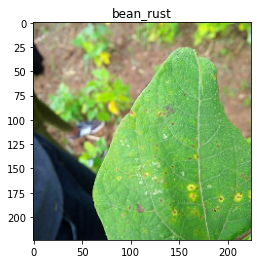

In [18]:
#retrive image for display purpouses
image, label = next(iter(train_ds))
_ = plt.imshow(image[0]/255)
_ = plt.title(get_label_name(label[0]))

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2)
])

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

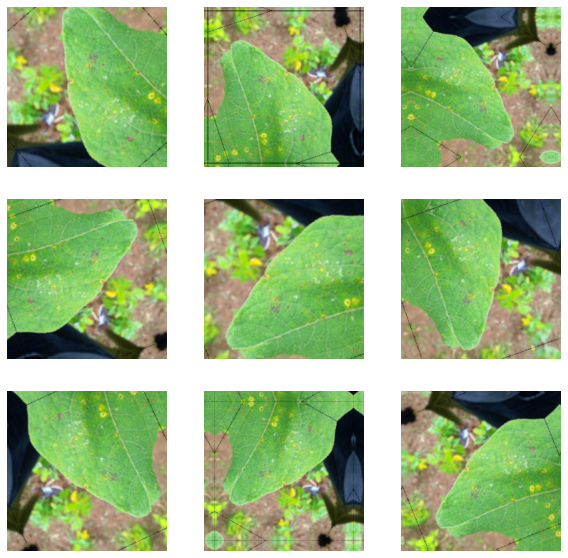

In [21]:
#display augmented images examples
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0]/255)
  plt.axis("off")

In [22]:
# Building model with data augmentation
model2 = tf.keras.Sequential([
  #preprocess resize and scale image
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),  
  #data augmentation
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  #model
  tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE,IMG_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3)
])


In [23]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy'])

In [24]:
model2.fit(train_ds, epochs=10,validation_data=test_ds)

Epoch 1/10
33/33 [==============================] - 25s 743ms/step - loss: 1.0426 - accuracy: 0.4932 - val_loss: 0.9937 - val_accuracy: 0.5312
Epoch 2/10
33/33 [==============================] - 24s 730ms/step - loss: 0.9133 - accuracy: 0.5735 - val_loss: 0.7710 - val_accuracy: 0.6719
Epoch 3/10
33/33 [==============================] - 24s 739ms/step - loss: 0.8303 - accuracy: 0.6180 - val_loss: 0.8015 - val_accuracy: 0.6328
Epoch 4/10
33/33 [==============================] - 24s 739ms/step - loss: 0.7786 - accuracy: 0.6518 - val_loss: 0.7019 - val_accuracy: 0.6484
Epoch 5/10
33/33 [==============================] - 24s 741ms/step - loss: 0.7346 - accuracy: 0.6789 - val_loss: 0.6332 - val_accuracy: 0.6875
Epoch 6/10
33/33 [==============================] - 25s 749ms/step - loss: 0.7023 - accuracy: 0.7012 - val_loss: 0.5995 - val_accuracy: 0.6953
Epoch 7/10
33/33 [==============================] - 25s 752ms/step - loss: 0.6766 - accuracy: 0.7224 - val_loss: 0.5498 - val_accuracy: 0.7266

### the accuracy improves a little and the overfit is eliminated 

but is not good enough, finally let’s try a transfer learning model, the data for the training is not large enough to train a more complex model, so let’s use a pretrained model and tuned for this application

In [47]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [48]:
#freeze base model
base_model.trainable = False
#display model summary
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [49]:
#add top layers to base model

inputs = tf.keras.Input(shape=IMG_SHAPE)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# A Dense classifier with three units, number of clases in this example
outputs = tf.keras.layers.Dense(3)(x)
model3 = tf.keras.Model(inputs, outputs)

In [52]:
base_learning_rate = 0.0001
model3.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model3.fit(train_ds, epochs=15,validation_data=test_ds)

Epoch 1/15
33/33 [==============================] - 36s 1s/step - loss: 1.3815 - accuracy: 0.2998 - val_loss: 1.1473 - val_accuracy: 0.3594
Epoch 2/15
33/33 [==============================] - 34s 1s/step - loss: 1.2284 - accuracy: 0.3926 - val_loss: 1.0038 - val_accuracy: 0.5000
Epoch 3/15
33/33 [==============================] - 34s 1s/step - loss: 1.0853 - accuracy: 0.4565 - val_loss: 0.9093 - val_accuracy: 0.5938
Epoch 4/15
33/33 [==============================] - 34s 1s/step - loss: 0.9692 - accuracy: 0.5513 - val_loss: 0.8367 - val_accuracy: 0.6406
Epoch 5/15
33/33 [==============================] - 27s 815ms/step - loss: 0.8003 - accuracy: 0.6547 - val_loss: 0.6965 - val_accuracy: 0.7500
Epoch 8/15
33/33 [==============================] - 28s 855ms/step - loss: 0.7508 - accuracy: 0.6876 - val_loss: 0.6662 - val_accuracy: 0.7734
Epoch 9/15
33/33 [==============================] - 25s 773ms/step - loss: 0.7691 - accuracy: 0.6625 - val_loss: 0.6386 - val_accuracy: 0.7812
Epoch 10/15

### The transfer model can’t completely adapt to the new dataset, let’s try some fine-tuning ad unfreeze some layers in order to increase accuracy

In [55]:
initial_epochs = 15
loss0, accuracy0 = model3.evaluate(test_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

4/4 [==============================] - 2s 610ms/step - loss: 0.5419 - accuracy: 0.8125
initial loss: 0.54
initial accuracy: 0.81


In [56]:
base_model.trainable = True

In [57]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [58]:
# Fine-tune from this layer onwards, unfreeze 55 layers
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [59]:
#fine tuning require a low learning rate
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [60]:
model3.fit(train_ds, epochs=10,validation_data=test_ds,callbacks=[tensorboard_callback])

Epoch 1/10
33/33 [==============================] - 49s 1s/step - loss: 0.5157 - accuracy: 0.7785 - val_loss: 0.3950 - val_accuracy: 0.8438
Epoch 2/10
33/33 [==============================] - 48s 1s/step - loss: 0.4640 - accuracy: 0.8095 - val_loss: 0.4126 - val_accuracy: 0.8438
Epoch 3/10
33/33 [==============================] - 46s 1s/step - loss: 0.3881 - accuracy: 0.8462 - val_loss: 0.2973 - val_accuracy: 0.8750
Epoch 4/10
33/33 [==============================] - 41s 1s/step - loss: 0.3453 - accuracy: 0.8801 - val_loss: 0.2855 - val_accuracy: 0.8828
Epoch 5/10
33/33 [==============================] - 40s 1s/step - loss: 0.3399 - accuracy: 0.8636 - val_loss: 0.2599 - val_accuracy: 0.8984
Epoch 6/10
33/33 [==============================] - 38s 1s/step - loss: 0.2941 - accuracy: 0.8849 - val_loss: 0.2404 - val_accuracy: 0.9219
Epoch 7/10
33/33 [==============================] - 50s 2s/step - loss: 0.2709 - accuracy: 0.8975 - val_loss: 0.2093 - val_accuracy: 0.9297
Epoch 8/10
33/33 [==

### the final accuracy after transfer learning and fine tuning is above 90%,

this is a really great improvement with respect to the base model, in order to future improve this we may try different base models or play with  the number of layers for the fine tuning, for the sake of this project and applications have 90% accuracy is good enough.

the final step for this project is the deployment, I like to try it but unfortunately with the recent changes in IBM Watson machine learning services (September 2020 update) I am unable to find proper documentation or working examples that allow me to do that step